데이터 로드 

In [ ]:
!unzip /content/drive/MyDrive/DataSet/전해탈지/Dataset.zip

라이브러리 모듈 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from glob import glob 
import tqdm

from sklearn.impute import SimpleImputer

# CSV 데이터 병합 

## csv 리스트 디렉토리 

In [3]:
csv_list_dir = glob('/content/data/*.csv')
csv_list_dir.remove( '/content/data/Error Lot list.csv',)
csv_list_dir.sort()

In [ ]:
csv_list_dir

## input 데이터 로드 

In [5]:
def add_date(df,dir):
  date = dir[-14:-4]
  df['date'] = date
  return df 
  
#init 
dir = csv_list_dir[0]
df = pd.read_csv(dir)
df = add_date(df,dir)

for dir in csv_list_dir[1:]:
  temp_df = pd.read_csv(dir)
  temp_df = add_date(temp_df,dir)
  df = pd.concat([df,temp_df],axis=0)

In [6]:
df.head()

,Index,Lot,Time,pH,Temp,Current,date
0,1,1,오후 4:29:15.0,10.37,42.87,7.34,2021.09.06
1,2,1,오후 4:29:20.0,10.90,42.70,8.26,2021.09.06
2,3,1,오후 4:29:25.0,9.61,42.37,8.46,2021.09.06
3,4,1,오후 4:29:30.0,10.32,45.85,8.04,2021.09.06
4,5,1,오후 4:29:35.0,10.36,44.18,7.23,2021.09.06


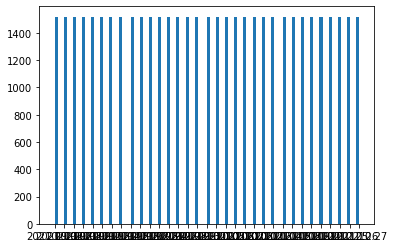

In [7]:
plt.hist(df['date'],bins=100)
plt.show()

모든 날짜의 행 수가는 동일 함 

## output 데이터 로드

In [8]:
error = pd.read_csv('/content/data/Error Lot list.csv')
error = error.fillna(0)
error['Date'] = error['Date'].apply(lambda x : x.replace('-','.')) # input 데이터랑 date 형태 통일 

## error 데이터 parsing 

In [9]:
df['error']=0

In [10]:
def add_error(df,error,index):
  date = error.iloc[index,:]['Date']
  LoT = error.iloc[index,:]['LoT']
  LoT2 = error.iloc[index,:]['LoT2']
  df.loc[(df['date']==date)&(df['Lot']==LoT),'error']=1
  df.loc[(df['date']==date)&(df['Lot']==LoT2),'error']=1
  return df

In [11]:
# 날짜, Lot별로 error가 있을 경우 1 입력 
for index in range(len(error)):
  df = add_error(df,error,index)

15.0
15


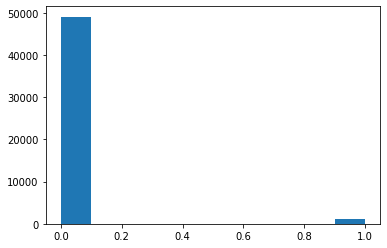

In [12]:
#정상적으로 입력 됬는지 확인 
print(len(df[df['error']==1])/69)
temp = np.array(error)[:,2:]
print(len(temp[temp!=0]))
plt.hist(df['error'])
plt.show()

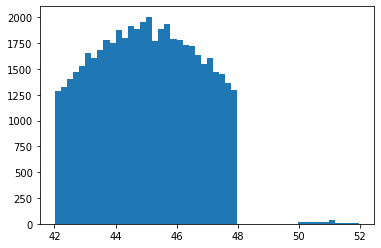

In [13]:
plt.hist(df['Temp'],bins=50)
plt.show()

# EDA 

In [ ]:
df.head()

,Index,Lot,Time,pH,Temp,Current,date,error
0,1,1,오후 4:29:15.0,10.37,42.87,7.34,2021.09.06,0
1,2,1,오후 4:29:20.0,10.90,42.70,8.26,2021.09.06,0
2,3,1,오후 4:29:25.0,9.61,42.37,8.46,2021.09.06,0
3,4,1,오후 4:29:30.0,10.32,45.85,8.04,2021.09.06,0
4,5,1,오후 4:29:35.0,10.36,44.18,7.23,2021.09.06,0


## 독립변수 - 종속변수 개별 적으로 비교 

In [ ]:
len(df.loc[df['date']=='2021.09.06'])

1518

하루 = 한 싸이클 = 1518 회 

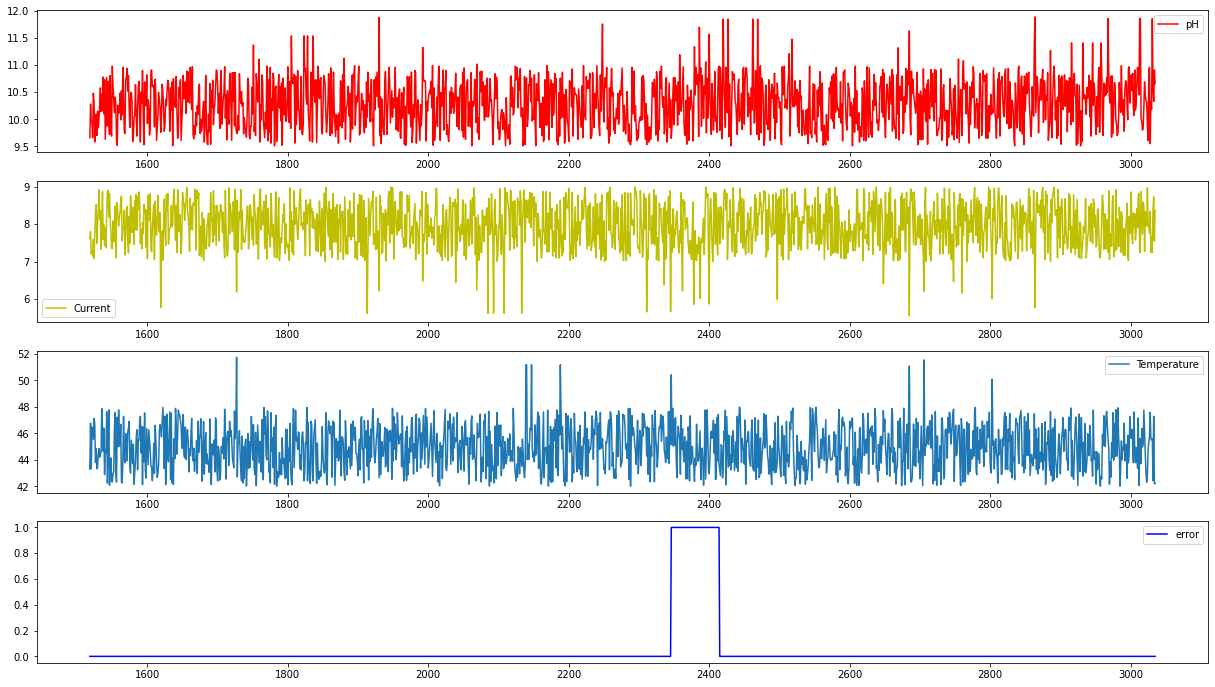

In [ ]:
index = np.arange(len(df))
i = 1518 
plt.figure(figsize=(21,12))
plt.subplot(4,1,1)
plt.plot(index[i:i*2],df['pH'][i:i*2],'r')
plt.legend(['pH'])
plt.subplot(4,1,2)
plt.plot(index[i:i*2],df['Current'][i:i*2],'y')
plt.legend(['Current'])
plt.subplot(4,1,3)
plt.plot(index[i:i*2],df['Temp'][i:i*2])
plt.legend(['Temperature'])
plt.subplot(4,1,4)
plt.plot(index[i:i*2],df['error'][i:i*2],'b')
plt.legend(['error'])
plt.show()

- 온도, pH, 전류밀도가 튀는 값들이 있지만 이것이 곧 바로 error로 연결되지는 않음 
- 단순 비교를 통해서는 error의 발생 요인을 알기 어려움 

## PCA
- 독립변수 - 종속변수를 개별적으로 보기 어려움으로 PCA를 통해 독립 변수를 한개의 차원으로 축소 하여 비교 

In [ ]:
pca_input = np.array(df[['pH','Temp','Current']])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1 )
pca_result = pca.fit_transform(pca_input)

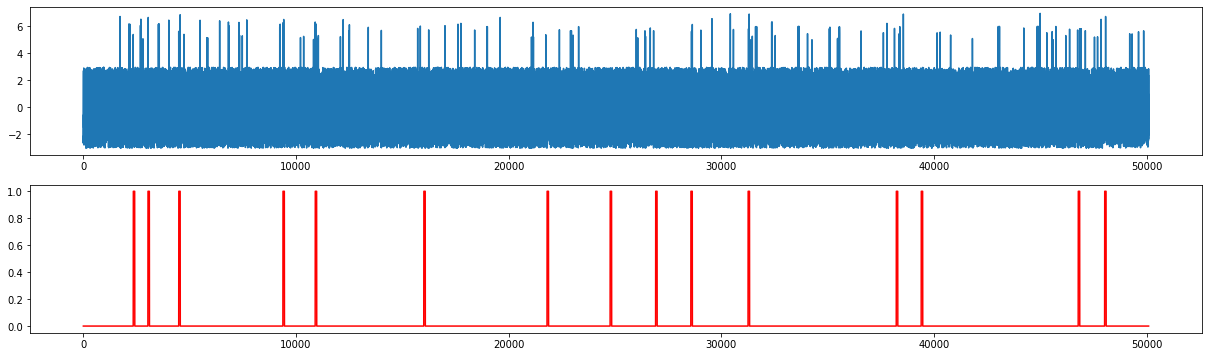

In [ ]:
plt.figure(figsize = (21,6))
plt.subplot(2,1,1)
plt.plot(index,pca_result)
plt.subplot(2,1,2)
plt.plot(index,df['error'],'r')
plt.show()

In [ ]:
date = np.zeros(len(df))
for i in range(0,len(df),1518):
  if i == 0:
    pass
  else:
    date[i]=1

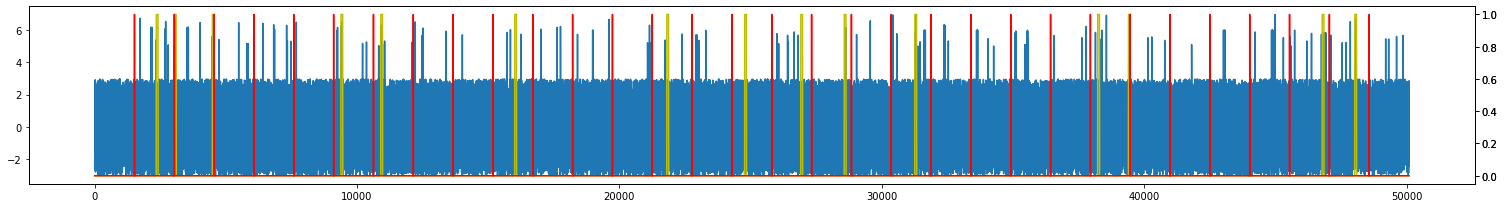

In [ ]:
fig, ax1 = plt.subplots(figsize=(21,3)) 

ax1.plot(index,pca_result) 

ax2 = ax1.twinx()
ax2.plot(index,df['error'],'y')

ax3 = ax1.twinx()
ax3.plot(index,date,'r')
plt.tight_layout()
plt.show()

- 시간이 갈 수록 에러가 누적되지 않음 -> 장비의 피로 누적으로 인한 error는 아님 
- red : 날짜별 분할 
- yellow : error 발생 포인트 
- blue : 차원 축소 한 독립변수 

error 직전의 패턴 파악이 필요 

## error 발생의 lot 패턴 파악 
- + 정상 lot의 패턴 파악 

# 새 섹션

In [ ]:
df

,Index,Lot,Time,pH,Temp,Current,date,error
0,1,1,오후 4:29:15.0,10.37,42.87,7.34,2021.09.06,0
1,2,1,오후 4:29:20.0,10.90,42.70,8.26,2021.09.06,0
2,3,1,오후 4:29:25.0,9.61,42.37,8.46,2021.09.06,0
3,4,1,오후 4:29:30.0,10.32,45.85,8.04,2021.09.06,0
4,5,1,오후 4:29:35.0,10.36,44.18,7.23,2021.09.06,0
...,...,...,...,...,...,...,...,...
1513,1514,22,오후 6:39:05.9,9.79,43.52,8.55,2021.10.27,0
1514,1515,22,오후 6:39:10.9,9.53,44.44,7.36,2021.10.27,0
1515,1516,22,오후 6:39:15.9,9.86,46.54,8.15,2021.10.27,0
1516,1517,22,오후 6:39:20.9,10.52,47.88,7.97,2021.10.27,0


In [ ]:
df.loc[df['error']==1]

,Index,Lot,Time,pH,Temp,Current,date,error
828,829,13,오후 5:34:03.2,9.65,50.42,7.97,2021.09.07,1
829,830,13,오후 5:34:08.2,9.88,45.15,7.25,2021.09.07,1
830,831,13,오후 5:34:13.2,10.33,47.89,8.40,2021.09.07,1
831,832,13,오후 5:34:18.2,10.77,45.04,8.41,2021.09.07,1
832,833,13,오후 5:34:23.2,9.90,47.05,7.37,2021.09.07,1
...,...,...,...,...,...,...,...,...
1030,1031,15,오후 5:53:34.7,10.95,43.65,7.05,2021.10.26,1
1031,1032,15,오후 5:53:39.7,9.71,45.72,7.14,2021.10.26,1
1032,1033,15,오후 5:53:44.7,9.92,47.64,8.95,2021.10.26,1
1033,1034,15,오후 5:53:49.7,9.73,42.80,8.47,2021.10.26,1


9월 7일 Lot 13과 10월 26일 15 

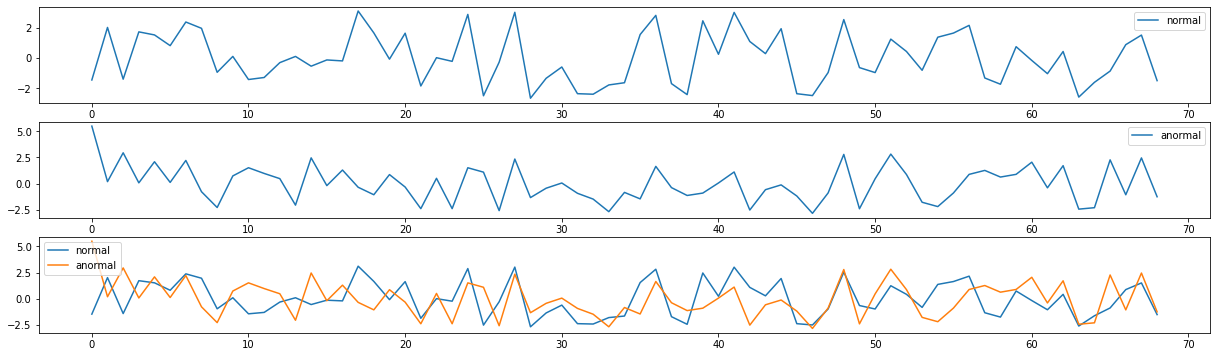

In [ ]:
#이상 
date = df['date']=='2021.09.07'
lot = df['Lot']==13
df1 = df[date&lot]

#정상 
date = df['date']=='2021.09.07'
lot = df['Lot']==1
df2 = df[date&lot]

#정상
from sklearn.decomposition import PCA
pca = PCA(n_components = 1 )
pca_result = pca.fit_transform(np.array(df2[['Temp','Current','pH']]))

from sklearn.decomposition import PCA
pca = PCA(n_components = 1 )
pca_result1 = pca.fit_transform(np.array(df1[['Temp','Current','pH']]))

plt.figure(figsize=(21,6))

plt.subplot(3,1,1)
plt.plot(index,pca_result)
plt.legend(['normal'])
plt.subplot(3,1,2)
plt.plot(index,pca_result1)
plt.legend(['anormal'])
plt.subplot(3,1,3)
plt.plot(index,pca_result,index,pca_result1)
plt.legend(['normal','anormal'])
plt.show()

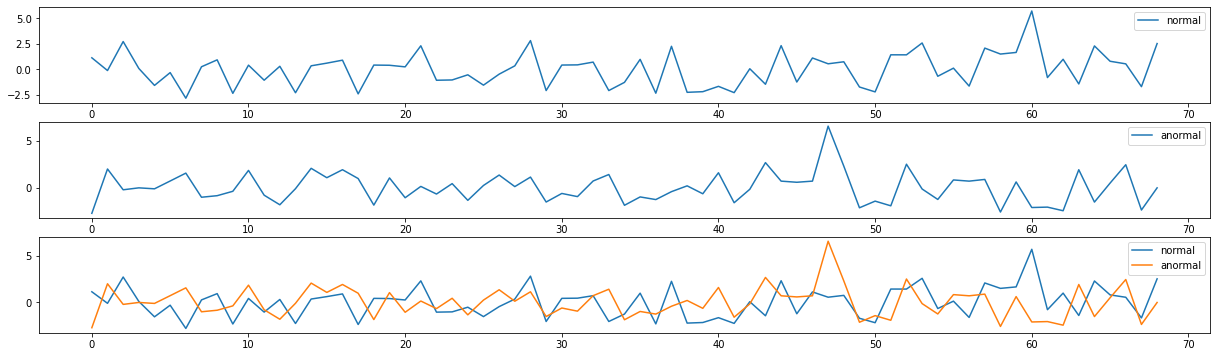

In [ ]:
#이상 
date = df['date']=='2021.10.26'
lot = df['Lot']==15
df1 = df[date&lot]

#정상 
date = df['date']=='2021.10.26'
lot = df['Lot']==1
df2 = df[date&lot]

#정상
from sklearn.decomposition import PCA
pca = PCA(n_components = 1 )
pca_result = pca.fit_transform(np.array(df2[['Temp','Current','pH']]))

from sklearn.decomposition import PCA
pca = PCA(n_components = 1 )
pca_result1 = pca.fit_transform(np.array(df1[['Temp','Current','pH']]))

plt.figure(figsize=(21,6))

plt.subplot(3,1,1)
plt.plot(index,pca_result)
plt.legend(['normal'])
plt.subplot(3,1,2)
plt.plot(index,pca_result1)
plt.legend(['anormal'])
plt.subplot(3,1,3)
plt.plot(index,pca_result,index,pca_result1)
plt.legend(['normal','anormal'])
plt.show()

단순 EDA로 패턴 파악 어려움 

## Value 분포 

### 정상 데이터 분포 

In [ ]:
df_normal = df[df['error']==0]

In [ ]:
df_anormal = df[df['error']==1]

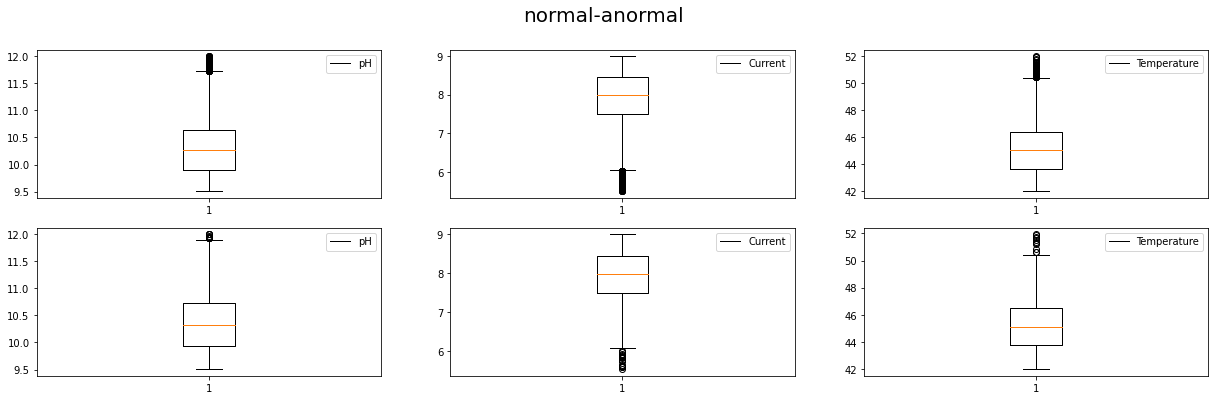

In [ ]:
index_normal = np.arange(len(df_normal))

fig = plt.figure(figsize=(21,6))
fig.suptitle('normal-anormal',fontsize=20)
plt.subplot(2,3,1)
plt.boxplot(df_normal['pH'])
plt.legend(['pH'])
plt.subplot(2,3,2)
plt.boxplot(df_normal['Current'])
plt.legend(['Current'])
plt.subplot(2,3,3)
plt.boxplot(df_normal['Temp'])
plt.legend(['Temperature'])

plt.subplot(2,3,4)
plt.boxplot(df_anormal['pH'])
plt.legend(['pH'])
plt.subplot(2,3,5)
plt.boxplot(df_anormal['Current'])
plt.legend(['Current'])
plt.subplot(2,3,6)
plt.boxplot(df_anormal['Temp'])
plt.legend(['Temperature'])
plt.show()

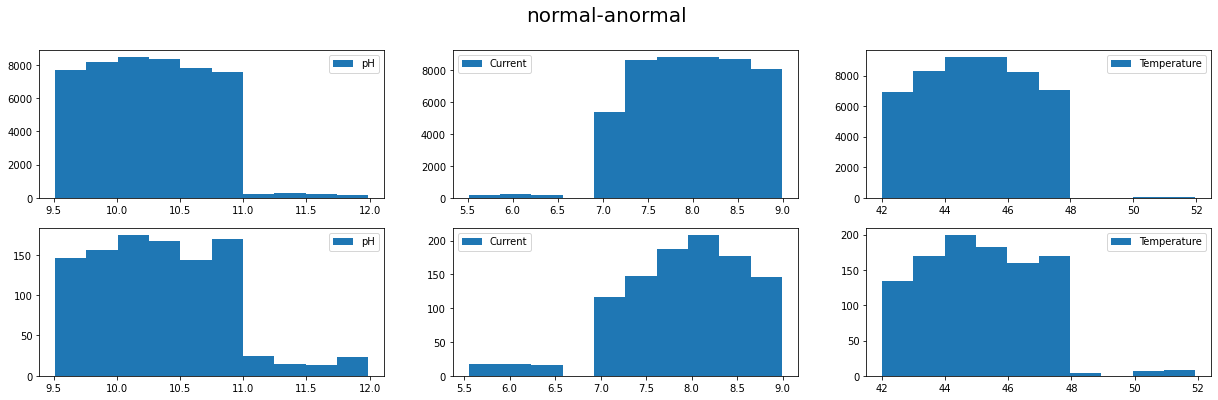

In [ ]:
index_normal = np.arange(len(df_normal))

fig = plt.figure(figsize=(21,6))
fig.suptitle('normal-anormal',fontsize=20)
plt.subplot(2,3,1)
plt.hist(df_normal['pH'])
plt.legend(['pH'])
plt.subplot(2,3,2)
plt.hist(df_normal['Current'])
plt.legend(['Current'])
plt.subplot(2,3,3)
plt.hist(df_normal['Temp'])
plt.legend(['Temperature'])

plt.subplot(2,3,4)
plt.hist(df_anormal['pH'])
plt.legend(['pH'])
plt.subplot(2,3,5)
plt.hist(df_anormal['Current'])
plt.legend(['Current'])
plt.subplot(2,3,6)
plt.hist(df_anormal['Temp'])
plt.legend(['Temperature'])
plt.show()

# 전처리

## 컬럼제거

In [14]:
input = df[['pH','Temp','Current','error']]

## Train - Test 분할 

In [15]:
index = int(len(df['date'].unique())*0.9)*1518
index

44022

In [16]:
train_input = input.iloc[:index,:]
test_input  = input.iloc[index:,:]

## train -> 정상, 비정상 분할 

In [17]:
train_normal = train_input[train_input['error']==0].drop(columns = 'error')
train_anormal = train_input[train_input['error']==1].drop(columns = 'error')

## 시계열 분할 

In [18]:
input = np.array(train_normal).reshape(-1,69,3)

#모델

In [19]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Bidirectional, LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [20]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=10)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=10,        # 대상ㅃ 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율

callbacks = [model_check_point, plot_losses, reduce_lr]

In [21]:
timesteps = 69
n_features =3 

In [22]:
#Env 데이터 파트 
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', input_shape=(timesteps,n_features), return_sequences=True)))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# #Env 데이터 파트 
# input = Input((timesteps,n_features)) #<---- shape 
# x = Bidirectional(LSTM(128,return_sequences= True,))(input) #bidirec
# x = BatchNormalization()(x)
# x = Bidirectional(LSTM(64,return_sequences= True))(input) #bidirec
# x = RepeatVector(timesteps)
# x = Bidirectional(LSTM(64,return_sequences= True))(input) #bidirec
# x = BatchNormalization()(x)
# x = Bidirectional(LSTM(128,return_sequences= True))(input) #bidirec
# output = TimeDistributed(Dense(n_features))
# model = Model(input,output)

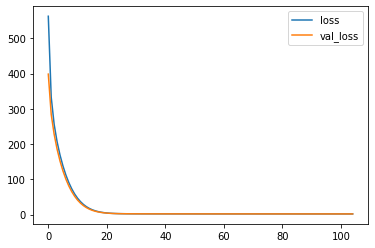

loss =  1.7573397159576416 , val_loss =  1.748742699623108
18/18 [==============================] - 1s 33ms/step - loss: 1.7573 - val_loss: 1.7487 - lr: 0.0010
Epoch 106/1000
 4/18 [=====>........................] - ETA: 0s - loss: 1.7585

KeyboardInterrupt: ignored

In [23]:
model.fit(input,input, epochs=1000, verbose=1, batch_size=32,validation_split=0.1,callbacks=callbacks)

## Train - anormal 판단 기준 거리 게산 
- 유클리디안 거리 

In [24]:
y_ = model.predict(input)
predicted = input-y_
predicted = predicted.reshape(-1,69*3)
predicted = predicted**2
predicted = predicted.sum(axis=1)
predicted = predicted**(0.5)
predicted.sort()

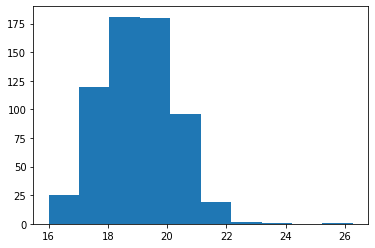

In [25]:
plt.hist(predicted)
plt.show()

In [26]:
index_standard = int(len(predicted)*0.90)
standard = predicted[index_standard]
standard
# 정상 기준 - 정상 데이터의 오차 95% 수준 

20.528135237562676

## test 데이터 대입 

In [27]:
test_x = np.array(test_input.drop(columns = 'error'))
test_x = test_x.reshape(-1,69,3)
test_y = np.array(test_input['error'])

In [28]:
y_ = model.predict(test_x)
predicted_test = test_x-y_
predicted_test = predicted_test.reshape(-1,69*3)
predicted_test = predicted_test**2
predicted_test = predicted_test.sum(axis=1)
predicted_test = predicted_test**(1/2)

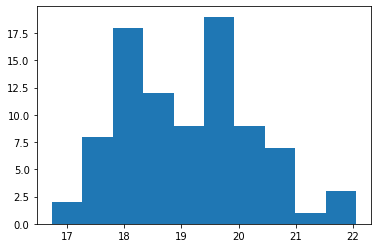

In [29]:
plt.hist(predicted_test)
plt.show()

In [30]:
a = np.where(predicted_test>standard)[0]
a

array([10, 12, 18, 19, 27, 40, 41, 47, 66, 81, 84])

In [31]:
test_y_ = test_y.reshape(-1,69).sum(axis=1)/69

In [32]:
np.where(test_y_==1)[0]

array([40, 58])